In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm.notebook import tqdm
import networkx as nx
import pyemma
import mdtraj
import pyemma.util.contexts
import pickle
from pathos.multiprocessing import Pool
from contextlib import closing
import seaborn as sns

## Estimation

In [2]:
topfile = '/group/ag_cmb/simulation-data/DESRES-Science2011-FastProteinFolding/DESRES-Trajectory_CLN025-0-protein/CLN025-0-protein/folded.pdb'

ref = mdtraj.load_pdb(topfile)

_dir = '/group/ag_cmb/simulation-data/DESRES-Science2011-FastProteinFolding/DESRES-Trajectory_CLN025-0-protein/CLN025-0-protein/'

# ATTENTION: desres is a single fragmented trajectory. pyemma will concatenate with nested loop
trajfiles = [[_dir + 'CLN025-0-protein-{:03d}.dcd'.format(n) for n in range(54)]]

In [3]:
first_resid = 1  # truncate n and c-terminal residues
system_integers = np.arange(first_resid, ref.top.n_residues - first_resid)

In [4]:
res_torsions = dict()

with pyemma.util.contexts.settings(show_progress_bars=False):
    for n in tqdm(system_integers):
        f = pyemma.coordinates.featurizer(topfile)

        f.add_backbone_torsions(selstr=f'resid {n}', cossin=True)
        try:
            f.add_sidechain_torsions(selstr=f'resid {n}', cossin=True)
        except ValueError:
            pass
        # make sure it's a list again...
        res_torsions[n] = [pyemma.coordinates.load(trajfiles, features=f, stride=5)]

  0%|          | 0/8 [00:00<?, ?it/s]

/storage/mi/thempel/anaconda3/envs/py37_feb21/lib/python3.8/site-packages/mdtraj/geometry/dihedral.py:374: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(x for x in indices if x.size)[id_sort]
/storage/mi/thempel/anaconda3/envs/py37_feb21/lib/python3.8/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


In [6]:
# choose lag time for vamp computation (in ns)
msmlag = 50

In [7]:
# all pairwise combinations of residue indices
args = list(itertools.combinations(system_integers, 2))

def get_edge_vamp2(n1, n2, stride=1):
    """
    Compute normalized dependency between two feature
    vectors using the VAMP2 score.
    
    :params:
    :n1: int, residue index of residue A
    :n2: int, residue index of residue B
    :stride: int, optional, used in covariance matrix estimation
    
    :returns:
    float, dependency for this link
    """
    with pyemma.util.contexts.settings(show_progress_bars=False):
        v1 = pyemma.coordinates.vamp(feature[n1], lag=msmlag, stride=stride)
        v2 = pyemma.coordinates.vamp(feature[n2], lag=msmlag, stride=stride)
        v12 = pyemma.coordinates.vamp([np.hstack([t1, t2]) for t1, t2 in zip(feature[n1], feature[n2])], lag=msmlag, stride=stride)

    s1 = v1.score(score_method='VAMP2')
    s2 = v2.score(score_method='VAMP2')
    s12 = v12.score(score_method='VAMP2')
    
    # note that pyemma returns the vamp score in the non-whitened space (+1)
    # i.e. we have to subtract 1 from each computed score
    d =  (s1 + s2 - 1 - s12) / min(s1 - 1, s2 - 1)
        
    return d

def get_edge_vamp1(n1, n2, stride=1):
    """
    Compute normalized dependency between two feature
    vectors using the VAMP1 score.
    
    :params:
    :n1: int, residue index of residue A
    :n2: int, residue index of residue B
    :stride: int, optional, used in covariance matrix estimation
    
    :returns:
    float, dependency for this link
    """
    with pyemma.util.contexts.settings(show_progress_bars=False):
        v1 = pyemma.coordinates.vamp(feature[n1], lag=msmlag, stride=stride)
        v2 = pyemma.coordinates.vamp(feature[n2], lag=msmlag, stride=stride)
        v12 = pyemma.coordinates.vamp([np.hstack([t1, t2]) for t1, t2 in zip(feature[n1], feature[n2])], lag=msmlag, stride=stride)

        s1 = v1.score(score_method='VAMP1')
        s2 = v2.score(score_method='VAMP1')
        s12 = v12.score(score_method='VAMP1')
        
        d =  (s1 + s2 - 1 - s12) / min(s1 - 1, s2 - 1)
        
    return d

In [8]:
feature = res_torsions

In [9]:
# VAMP-1 graph
# initialize networkx graph object
graph_vamp1 = nx.Graph()


# multiprocessing w/ progress bar
pbar = tqdm(total=len(args))
pool = Pool(processes=8)
with closing(pool):
    # compute pairwise dependency on each pair of residues, populate graph edges
    res_async = [pool.apply_async(get_edge_vamp1, a, callback=lambda _: pbar.update(1)) for a in args]
    [graph_vamp1.add_edge(*a, weight=x.get()) for x, a in zip(res_async, args)]
    
pbar.close()

  0%|          | 0/28 [00:00<?, ?it/s]

In [10]:
# VAMP-2 graph
# initialize networkx graph object
graph_vamp2 = nx.Graph()

# multiprocessing w/ progress bar
pbar = tqdm(total=len(args))
pool = Pool(processes=8)
with closing(pool):
    # compute pairwise dependency on each pair of residues, populate graph edges
    res_async = [pool.apply_async(get_edge_vamp2, a, callback=lambda _: pbar.update(1)) for a in args]
    [graph_vamp2.add_edge(*a, weight=x.get()) for x, a in zip(res_async, args)]
    
pbar.close()

  0%|          | 0/28 [00:00<?, ?it/s]

## Visualization

In [11]:
# set node sizes and edge widths
nodesize = 20
edgewidth = 1

# define color for edges
_c = (0., 0., 0.)
edge_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("uwe", [(*_c, 0), (*_c, 0),
                                                                            (*_c, 0.5), (*_c, 1)])

In [12]:
# Fruchterman-Reingold (FR) node positioning
# please note that FR is stochastic and results might be slightly different
# for each execution

ks = [.01, 0.012] # FR hyperparameter

pos_dicts = []
frugold_projections = []
for n, graph in enumerate([graph_vamp1, graph_vamp2]):

    # use networkx implementation of FR algorithm
    pos_dict = nx.spring_layout(graph, k=ks[n], 
                                iterations=5000, threshold=0.00001)
    pos_dicts.append(pos_dict)
    frugold_projections.append(np.array([pos_dict[r] for r in system_integers]))

In [13]:
# color definitions
sns_pal = sns.color_palette('hls', 4)
vmd_colors = np.array(sns_pal)
col_pal = ['#80aee7ff', '#e68082ff']  # for histograms

In [14]:
# cluster FR projected data with k-means
# remember that k-means is stochastic and might produce slightly different 
# results each for each run. this step further depends on the result of
# the FR algorithm, i.e., it might be necessary to adjust hyperparameters

# chignolin: no clusters visible
n_clusters = [4, 1] # number of nodes for vamp-1 / vamp-2 projections

assignments = []
cluster_objs = []

for n, (k, xy) in enumerate(zip(n_clusters, frugold_projections)):
    # cluster in projected space
    cl = pyemma.coordinates.cluster_kmeans(xy, k=k, tolerance=1e-7, 
                                           max_iter=100)
    cluster_objs.append(cl)
    assignments.append(cl.dtrajs[0])

initialize kmeans++ centers:   0%|          | 0/4 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
matched_assignments = assignments

In [16]:
# to quantify the differences between a) dependencies of
# nodes in a cluster and b) dependencies between nodes of different clusters, 
# each node has to be viewed from its strongest embedding into the network. 
# 
# Example: network consisting of 3 nodes [n1, n2, n3]. If dependency scores 
# between (n1, n2) and (n2, n3) are very high, the network cannot be decomposed
# irrespectively of how low the dependency is for (n1, n3).
    
# This means that the dependency between a single node n and a set of nodes C
# should be viewed by taking the max of all edges between n and all nodes of C. 

intra_cluster_edge_list, inter_cluster_edge_list = [], []
for assignments, graph, _n_clusters in zip(matched_assignments, 
                                           [graph_vamp1, graph_vamp2], 
                                          n_clusters):
        
    # group cluster nodes together
    node_groups = [np.array(list(graph.nodes))[np.where(assignments == n)[0]] \
                   for n in np.unique(assignments)]

    # extract edges within each cluster and between two clusters
    inter_cluster_edges = []
    intra_cluster_edges = []
    
    # iterate over all combinations of clusters
    # -> extract inter-cluster edges
    for cluster_i, cluster_j in itertools.combinations(range(_n_clusters), 2):
        
        _inter_cluster_edges = []

        # max link between (each member of cluster i) and (all members of cluster j)
        for node_i in node_groups[cluster_i]:
            w_to_all_cluster_j = [graph.get_edge_data(node_i, node_j)['weight'] for \
                                  node_j in node_groups[cluster_j]]
            _inter_cluster_edges.append(max(w_to_all_cluster_j))

        # max link between (each member of cluster j) and (all members of cluster i)
        for node_j in node_groups[cluster_j]:
            w_to_all_cluster_i = [graph.get_edge_data(node_i, node_j)['weight'] for \
                                  node_i in node_groups[cluster_i]]
            _inter_cluster_edges.append(max(w_to_all_cluster_i))
        
        inter_cluster_edges += _inter_cluster_edges

    # iterate over every cluster
    # -> extract intra-cluster edges
    for cluster_i in range(_n_clusters):
        
        _intra_cluster_edges = []
        
        # max link within a single cluster of nodes, i.e., get max edge between node and 
        # all other members of the same cluster
        for node_i in node_groups[cluster_i]:
            w_to_all_in_cluster = [graph.get_edge_data(node_i, node_j)['weight'] for \
                                   node_j in node_groups[cluster_i] if node_i!=node_j]
            if len(w_to_all_in_cluster) > 0:
                _intra_cluster_edges.append(max(w_to_all_in_cluster))

        intra_cluster_edges += _intra_cluster_edges

    inter_cluster_edge_list.append(np.array(inter_cluster_edges))
    intra_cluster_edge_list.append(np.array(intra_cluster_edges))

In [17]:
def plot_dependency_graph(ax, _graph, pos_dict, assigments, edge_lcutoff=.3, nodelabels=False):
    """
    Plots the dependency graph using networkx and matplotlib.pyplot.
    :params:
    :ax: plt.Axes object, populated by this function
    :_graph: nx.Graph object, graph to show
    :pos_dict: dict, contains positions of graph nodes
    :assignments: list, assignment of colors (to match VMD output)
    :edge_lcutoff: float, cutoff value for edge weights; everything 
    below will not be shown
    :nodelabels: bool, optional, default: False. for matching clusters with VMD representation
    
    :returns:
    :ax: populated plt.Axes object
    :pc: matplotlib.collections.LineCollection of network edges
    """
    # remove invisible paths from graph (decreases SVG file size later)
    graph = nx.Graph()
    graph.add_nodes_from(_graph.nodes)
    for edge in _graph.edges():
        w = _graph.get_edge_data(*edge)['weight']
        if w > edge_lcutoff:
            graph.add_edge(*edge, weight=w)
    
    weights = np.array(list(nx.get_edge_attributes(graph, 'weight').values()))

    nx.draw_networkx_nodes(graph, 
                           node_size=nodesize,
                           pos=pos_dict, 
                           ax=ax, 
                           node_color=vmd_colors[assigments])
    
    if nodelabels:
        nx.draw_networkx_labels(graph, pos_dict, font_size=6)

    pc = nx.draw_networkx_edges(graph, 
                                edge_color=weights, 
                                width=edgewidth, 
                                pos=pos_dict, 
                                node_size=nodesize,
                                ax=ax, 
                                edge_cmap=edge_cmap, 
                                edge_vmax=1, 
                                edge_vmin=0
                               )
    
    return ax, pc

In [18]:
def plot_(gs, _graph, _pos_dict, _matched_assignment, _inter_cluster_edges, _intra_cluster_edges, ni=0, nf=-1):
    fullax = fig.add_subplot(gs[:, ni:nf])
    fullax.axis('off')

    # network plot
    ax = fig.add_subplot(gs[:, ni:ni+95])

    ax, pc = plot_dependency_graph(ax, _graph, _pos_dict, _matched_assignment)
    ax.axis('off')

    # colorbar
    cbar_ax = fig.add_subplot(gs[:, ni+102:ni+105])
    cb = fig.colorbar(pc, cax=cbar_ax)

    # histograms
    ax = fig.add_subplot(gs[:, ni+125:nf])
    sns.kdeplot(y=_inter_cluster_edges, fill=True, ax=ax, color=col_pal[0], linewidth=2)
    sns.kdeplot(y=_intra_cluster_edges, fill=True, ax=ax, color=col_pal[1], linewidth=2)


    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_xlabel('')

    # comment following line to verify that axes are matching
    for loc in ['top', 'right', 'bottom']:
        ax.spines[loc].set_visible(False)
    ax.set_yticklabels([]);
    
    return fullax

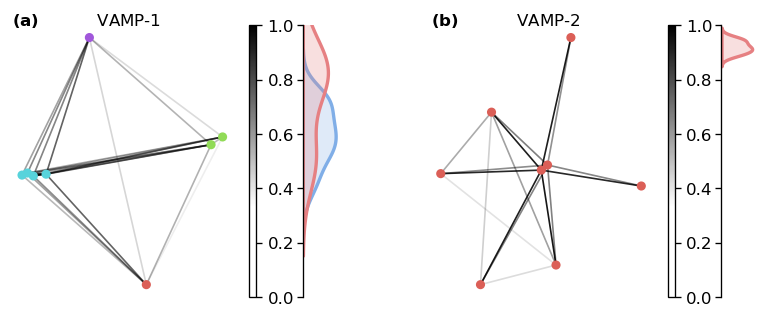

In [19]:
fig = plt.figure(figsize=(8, 3), dpi=120)
gs = fig.add_gridspec(65, 320)

ax = plot_(gs, graph_vamp1, pos_dicts[0], matched_assignments[0], inter_cluster_edge_list[0], intra_cluster_edge_list[0],
           nf=140)
ax.text(0, 1, r'$\mathbf{(a)}$' + 11*' ' + 'VAMP-1', transform=ax.transAxes)
ax = plot_(gs, graph_vamp2, pos_dicts[1], matched_assignments[1], inter_cluster_edge_list[1], intra_cluster_edge_list[1],
           ni=180)
ax.text(0, 1, r'$\mathbf{(b)}$' + 11*' ' +'VAMP-2', transform=ax.transAxes)

fig.savefig('/tmp/chignolin.pdf', bbox_inches='tight')

In [20]:
# Please note that results are subject to stochasticity from Fruchterman-Reingold and k-means algorithms.

# VAMP-1 network does not show significant differences between intra-cluster and inter-cluster
# dependencies, i.e., no indication that dynamics can be decomposed into subsystems.
# VAMP-2 network does not show any clustering at all.
# Interpretation: Peptide is too small to express any independent subunits, IMD cannot be applied.